# Audio Transcription Debug

Focused notebook to debug why Jarvis recordings fail on Qwen2.5-Omni while JFK sample works.

Cells: Load audio → Analyze & preprocess → Mel diagnostic → Load 7B → Transcribe (length tests)

In [ ]:
# Cell 0: Convert Jarvis .pcm recording to .wav
# Jarvis records raw PCM: signed 16-bit little-endian, 16kHz, mono
import os, wave

# --- Set your .pcm file path here ---

RECORDINGS_DIR = os.path.expanduser(
    "~/Library/Application Support/com.jarvis.app/recordings"
)
PCM_FILE = os.path.join(RECORDINGS_DIR, "20260227_011536.pcm")
SAMPLE_AUDIO = 'test_audio.wav'

pcm_size = os.path.getsize(PCM_FILE)
full_duration = pcm_size / (16000 * 2)
print(f"Source: {os.path.basename(PCM_FILE)} ({full_duration:.0f}s)")

with open(PCM_FILE, "rb") as pcm:
    pcm_data = pcm.read()

with wave.open(SAMPLE_AUDIO, "wb") as wav:
    wav.setnchannels(1)
    wav.setsampwidth(2)  # 16-bit = 2 bytes
    wav.setframerate(16000)
    wav.writeframes(pcm_data)

print(f"Saved full recording to {SAMPLE_AUDIO} ({full_duration:.0f}s)")

FileNotFoundError: [Errno 2] No such file or directory: 'recording.pcm'

In [ ]:
# Cell 0b: Play audio files in notebook
from IPython.display import Audio, display, HTML

for f in [SAMPLE_AUDIO, JFK_AUDIO]:
    if os.path.exists(f):
        display(HTML(f'<b>{f}</b>'))
        display(Audio(f))

In [1]:
# Cell 1: Common setup
import time, os, gc
import numpy as np
import librosa
import soundfile as sf
from huggingface_hub import snapshot_download

class timer:
    def __init__(self, label): self.label = label
    def __enter__(self): self.start = time.time(); return self
    def __exit__(self, *a): print(f"  {self.label}: {time.time()-self.start:.2f}s")

MODELS_DIR = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'models')

def ensure_model(repo_id, local_name=None):
    local_name = local_name or repo_id.split('/')[-1]
    local_path = os.path.join(MODELS_DIR, local_name)
    if not os.path.exists(local_path):
        print(f'Downloading {repo_id}...')
        snapshot_download(repo_id=repo_id, local_dir=local_path)
    else:
        print(f'Using local: {local_path}')
    return local_path

# Audio files
SAMPLE_AUDIO = 'test_audio.wav'       # Jarvis recording (quiet, ~37s)
JFK_AUDIO = 'test_audio 11.04.46\u202fPM.wav'  # JFK sample (clean, ~11s)

for f in [SAMPLE_AUDIO, JFK_AUDIO]:
    if os.path.exists(f):
        a, sr = librosa.load(f, sr=16000)
        print(f'{f}: {len(a)/sr:.1f}s | RMS={np.sqrt(np.mean(a**2)):.4f} | Peak={np.abs(a).max():.4f}')
    else:
        print(f'{f}: NOT FOUND')

/Users/ankit/code/learn/jarvis_aws/jarvis_aws/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


test_audio.wav: 36.7s | RMS=0.0289 | Peak=0.4268
test_audio 11.04.46 PM.wav: 11.0s | RMS=0.1421 | Peak=0.7827


In [2]:
# Cell 2: Analyze, preprocess, and normalize audio
from scipy import signal

audio, sr = librosa.load(SAMPLE_AUDIO, sr=16000)
rms = np.sqrt(np.mean(audio**2))
peak = np.abs(audio).max()
dc_offset = np.mean(audio)

print(f'File:      {SAMPLE_AUDIO}')
print(f'Duration:  {len(audio)/sr:.1f}s | SR: {sr}Hz')
print(f'RMS:       {rms:.4f}  (speech: 0.05-0.2)')
print(f'Peak:      {peak:.4f}')
print(f'DC offset: {dc_offset:.6f}')

# Per-second energy
print(f'\nEnergy per second:')
for i in range(0, len(audio), sr):
    chunk = audio[i:i+sr]
    chunk_rms = np.sqrt(np.mean(chunk**2))
    bar = '#' * int(chunk_rms * 200)
    print(f'  {i/sr:5.0f}s: {chunk_rms:.4f} {bar}')

# --- Preprocessing ---
processed = audio.copy()
applied = []

# 1. DC offset removal
if abs(dc_offset) > 0.001:
    processed = processed - np.mean(processed)
    applied.append(f'DC offset removed ({dc_offset:.6f})')

# 2. High-pass filter at 80Hz
b, a = signal.butter(4, 80 / (sr/2), btype='high')
processed = signal.filtfilt(b, a, processed).astype(np.float32)
applied.append('High-pass filter at 80Hz')

# 3. RMS normalization
PREPROCESSED_AUDIO = SAMPLE_AUDIO.rsplit('.', 1)[0] + '_preprocessed.wav'
new_rms = np.sqrt(np.mean(processed**2))
if new_rms < 0.05:
    gain = 0.1 / new_rms
    processed = np.clip(processed * gain, -1.0, 1.0)
    applied.append(f'RMS normalized (gain={gain:.1f}x)')

final_rms = np.sqrt(np.mean(processed**2))
final_peak = np.abs(processed).max()

if applied:
    sf.write(PREPROCESSED_AUDIO, processed, sr)
    print(f'\nPreprocessing:')
    for step in applied: print(f'  - {step}')
    print(f'\nBefore: RMS={rms:.4f}, Peak={peak:.4f}')
    print(f'After:  RMS={final_rms:.4f}, Peak={final_peak:.4f}')
    print(f'Exported: {PREPROCESSED_AUDIO}')
    SAMPLE_AUDIO = PREPROCESSED_AUDIO
else:
    print('\nAudio levels OK.')

File:      test_audio.wav
Duration:  36.7s | SR: 16000Hz
RMS:       0.0289  (speech: 0.05-0.2)
Peak:      0.4268
DC offset: 0.000003

Energy per second:
      0s: 0.0349 ######
      1s: 0.0212 ####
      2s: 0.0367 #######
      3s: 0.0330 ######
      4s: 0.0207 ####
      5s: 0.0314 ######
      6s: 0.0313 ######
      7s: 0.0334 ######
      8s: 0.0152 ###
      9s: 0.0367 #######
     10s: 0.0257 #####
     11s: 0.0188 ###
     12s: 0.0276 #####
     13s: 0.0392 #######
     14s: 0.0301 ######
     15s: 0.0340 ######
     16s: 0.0256 #####
     17s: 0.0325 ######
     18s: 0.0256 #####
     19s: 0.0200 ###
     20s: 0.0347 ######
     21s: 0.0243 ####
     22s: 0.0289 #####
     23s: 0.0255 #####
     24s: 0.0250 ####
     25s: 0.0284 #####
     26s: 0.0265 #####
     27s: 0.0295 #####
     28s: 0.0281 #####
     29s: 0.0295 #####
     30s: 0.0357 #######
     31s: 0.0274 #####
     32s: 0.0300 #####
     33s: 0.0335 ######
     34s: 0.0209 ####
     35s: 0.0218 ####
     36s: 0.0

JFK mel:    (128, 1100) | range: [-0.506, 1.494] | mean: 0.107
Jarvis mel: (128, 3674) | range: [-0.645, 1.355] | mean: 0.124


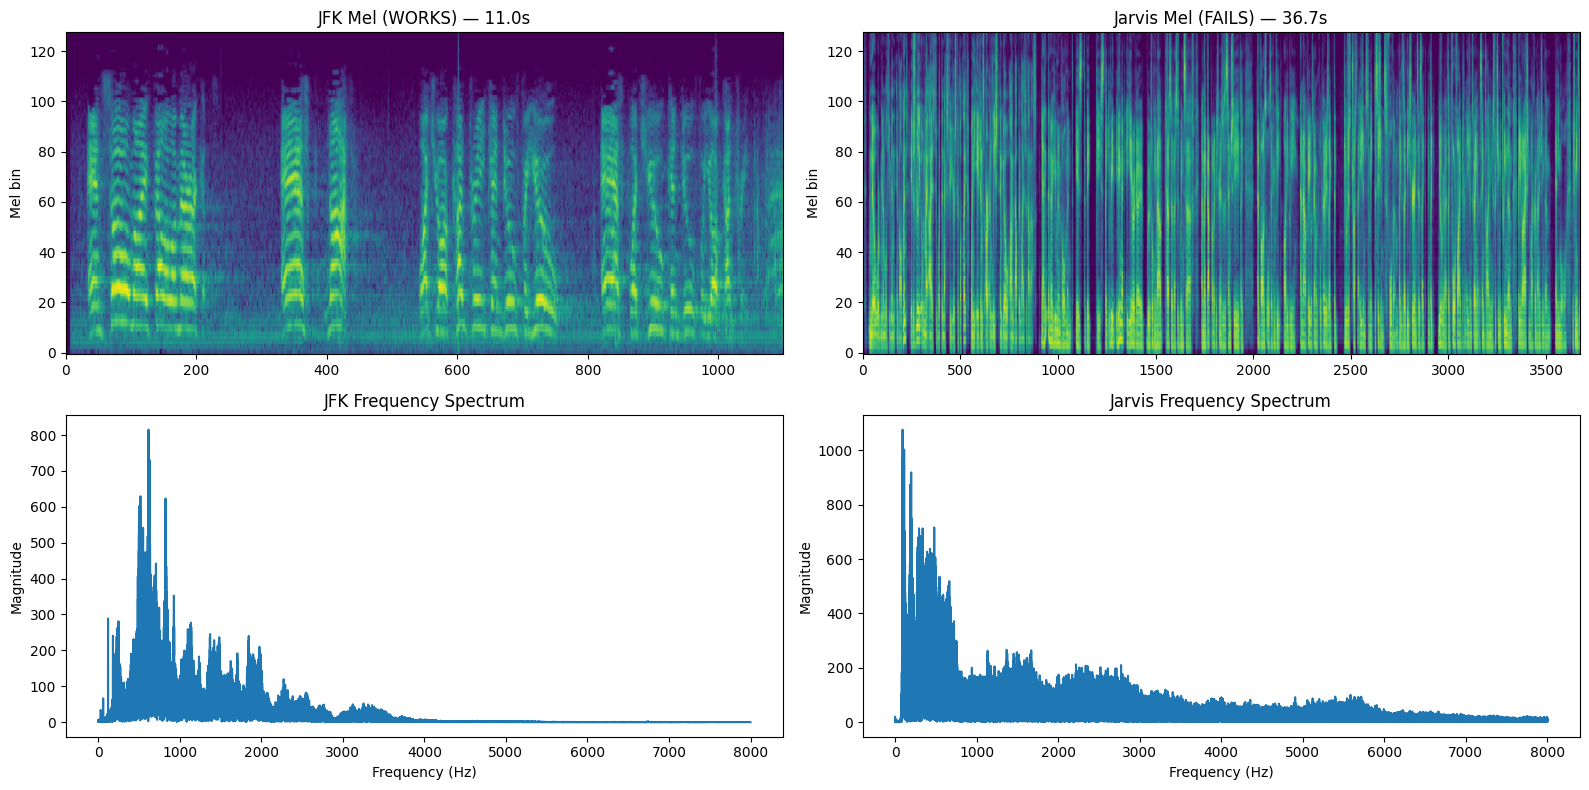


Active mel bins (>0): JFK=58.8% | Jarvis=59.8%

Mel energy by band:
  Low (0-32): JFK=0.445 | Jarvis=0.406
  Mid (32-80): JFK=0.250 | Jarvis=0.145
  High (80-128): JFK=-0.261 | Jarvis=-0.086


In [3]:
# Cell 3: Mel spectrogram & frequency diagnostic
import matplotlib.pyplot as plt
from mlx_lm_omni.audio_mel import AudioMel, AudioMelConfig

audio_jfk, sr = librosa.load(JFK_AUDIO, sr=16000)
audio_jarvis, sr = librosa.load(SAMPLE_AUDIO, sr=16000)

mel_fn = AudioMel(AudioMelConfig())
mel_jfk = mel_fn(audio_jfk)
mel_jarvis = mel_fn(audio_jarvis)

print(f'JFK mel:    {mel_jfk.shape} | range: [{mel_jfk.min():.3f}, {mel_jfk.max():.3f}] | mean: {mel_jfk.mean():.3f}')
print(f'Jarvis mel: {mel_jarvis.shape} | range: [{mel_jarvis.min():.3f}, {mel_jarvis.max():.3f}] | mean: {mel_jarvis.mean():.3f}')

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

axes[0, 0].imshow(mel_jfk, aspect='auto', origin='lower', cmap='viridis')
axes[0, 0].set_title(f'JFK Mel (WORKS) — {audio_jfk.shape[0]/sr:.1f}s')
axes[0, 0].set_ylabel('Mel bin')

axes[0, 1].imshow(mel_jarvis, aspect='auto', origin='lower', cmap='viridis')
axes[0, 1].set_title(f'Jarvis Mel (FAILS) — {audio_jarvis.shape[0]/sr:.1f}s')
axes[0, 1].set_ylabel('Mel bin')

for idx, (audio_data, label) in enumerate([(audio_jfk, 'JFK'), (audio_jarvis, 'Jarvis')]):
    fft = np.abs(np.fft.rfft(audio_data))
    freqs = np.fft.rfftfreq(len(audio_data), 1/sr)
    mask = freqs <= 8000
    axes[1, idx].plot(freqs[mask], fft[mask])
    axes[1, idx].set_title(f'{label} Frequency Spectrum')
    axes[1, idx].set_xlabel('Frequency (Hz)')
    axes[1, idx].set_ylabel('Magnitude')

plt.tight_layout()
plt.savefig('mel_comparison.png', dpi=100)
plt.show()

# Stats
jfk_active = (mel_jfk > 0).sum() / mel_jfk.size * 100
jarvis_active = (mel_jarvis > 0).sum() / mel_jarvis.size * 100
print(f'\nActive mel bins (>0): JFK={jfk_active:.1f}% | Jarvis={jarvis_active:.1f}%')
print(f'\nMel energy by band:')
for name, s, e in [('Low (0-32)', 0, 32), ('Mid (32-80)', 32, 80), ('High (80-128)', 80, 128)]:
    print(f'  {name}: JFK={mel_jfk[s:e].mean():.3f} | Jarvis={mel_jarvis[s:e].mean():.3f}')

In [ ]:
# Cell 4: Load Qwen2.5-Omni-7B
from mlx_lm_omni import load, generate
import mlx.core as mx

MODEL_7B = "giangndm/qwen2.5-omni-3b-mlx-8bit"
model_7b_path = ensure_model(MODEL_7B)

with timer('Model load (7B)'):
    model_7b, tokenizer_7b = load(model_7b_path)

# Fix conv weights — 7B ships in PyTorch layout
at = model_7b.thinker.audio_tower
if at.conv1.weight.shape[1] != 3:
    at.conv1.weight = mx.swapaxes(at.conv1.weight, 1, 2)
    at.conv2.weight = mx.swapaxes(at.conv2.weight, 1, 2)
    print('Fixed conv weights: PyTorch -> MLX layout')

print(f'Loaded: {MODEL_7B}')

In [ ]:
# Cell 5: Transcribe — comprehensive tests
# Tests: raw vs preprocessed, different volumes, verify float32
import textwrap

# First: verify the float32 fix is active in the loaded tokenizer
mel_instance = tokenizer_7b._audio_mel
print(f'AudioMel mel_filters dtype: {mel_instance.mel_filters.dtype}')
test_wav = np.zeros(16000, dtype=np.float32)
test_mel = mel_instance(test_wav)
print(f'Output mel dtype: {test_mel.dtype}')
print(f'Float32 fix active: {mel_instance.mel_filters.dtype == np.float32}')
print('=' * 80)

# Load raw (unprocessed) audio
raw_audio, sr = librosa.load('test_audio.wav', sr=16000)

test_configs = [
    (JFK_AUDIO,    None, None,  'JFK (baseline)'),
    ('test_audio.wav', None, None, 'Jarvis RAW (no preprocessing)'),
    ('test_audio.wav', 11, None,   'Jarvis RAW first 11s'),
    ('test_audio.wav', None, 0.15, 'Jarvis RAW boosted to RMS=0.15'),
    (SAMPLE_AUDIO, None, None,     'Jarvis preprocessed'),
    (SAMPLE_AUDIO, 11, None,       'Jarvis preprocessed first 11s'),
]

for test_file, trim_seconds, target_rms, label in test_configs:
    if not os.path.exists(test_file):
        print(f'SKIP (not found): {test_file}\n')
        continue

    audio, sr = librosa.load(test_file, sr=16000)
    if trim_seconds is not None:
        audio = audio[:int(trim_seconds * sr)]
    
    # Boost volume if requested (simple gain, no filtering)
    if target_rms is not None:
        current_rms = np.sqrt(np.mean(audio**2))
        if current_rms > 0:
            audio = audio * (target_rms / current_rms)
            audio = np.clip(audio, -1.0, 1.0).astype(np.float32)

    peak = np.abs(audio).max()
    rms = np.sqrt(np.mean(audio**2))
    print(f'[{label}]')
    print(f'  {len(audio)/sr:.1f}s | Peak={peak:.4f} | RMS={rms:.4f}')

    # Clear embedding queue
    embed = model_7b.thinker.model.embed_tokens
    embed.extended_embedding_queue.clear()

    messages = [
        {'role': 'system', 'content': 'You are a helpful assistant.'},
        {'role': 'user', 'content': (
            'First, identify the language spoken in this audio. '
            'Then transcribe the audio verbatim in that original language. '
            'Do NOT translate. Output format:\n'
            'Language: <detected language>\n'
            'Transcript: <verbatim transcription in original language>'
        ), 'audio': audio},
    ]
    prompt = tokenizer_7b.apply_chat_template(messages, add_generation_prompt=True)

    # prefill_step_size must cover the entire prompt to avoid splitting
    # the audio token region across multiple prefill chunks (which breaks
    # the ExtendedEmbedding queue — it only has 1 entry per audio).
    with timer('transcription'):
        text = generate(model_7b, tokenizer_7b, prompt=prompt, verbose=False,
                        max_tokens=500, prefill_step_size=len(prompt))

    print(f'\n  Transcript:')
    for line in textwrap.wrap(text.strip(), width=80):
        print(f'    {line}')
    print('=' * 80)

In [ ]:
# Cell 6: Cleanup
del model_7b, tokenizer_7b
gc.collect()
mx.clear_cache()
print('Memory cleared.')

# Findings & Fix (2026-02-27)

## Root Cause: Incorrect chunk processing in `mlx-lm-omni` AudioTower

The `mlx-lm-omni` library (v0.1.3 by giangndm) has a critical bug in `audio_tower.py` line 142.

**How Qwen2.5-Omni AudioTower works:**
- Audio is converted to a mel spectrogram, then split into chunks of 200 mel frames (~2s each)
- Each chunk gets positional embeddings (0–99) and passes through a transformer
- Original Qwen uses **block-diagonal attention** — each chunk attends only to itself

**The bug:** `mlx-lm-omni` reshapes all chunks into a single sequence *before* the transformer:
```python
# BROKEN (original mlx-lm-omni):
x = x + embed_pos
x = mx.reshape(x, (1, x.shape[0] * x.shape[1], x.shape[2]))[:, :x_size, :]  # ← merge here
for block in self.layers:
    x, _, _ = block(x)  # full cross-chunk attention with repeated pos embeddings!
```

This means for 37s Jarvis audio (19 chunks), positional embeddings 0–99 repeat 19 times in a single 1837-frame sequence with full attention — completely confusing the model.

JFK (11s, 6 chunks, 550 frames) barely survived because the signal is strong and chunk count is small.

**The fix:** Move reshape to *after* the transformer so each chunk processes independently as a batch element:
```python
# FIXED:
x = x + embed_pos
for block in self.layers:
    x, _, _ = block(x)  # each chunk is a batch element → independent attention (correct!)
x = mx.reshape(x, (1, x.shape[0] * x.shape[1], x.shape[2]))[:, :x_size, :]  # ← merge after
```

## Secondary fix: float32 precision in `audio_mel.py`
- `mel_filters`, `waveform`, and `window` were cast to float16, causing precision loss on quiet audio
- Changed all three to float32 — good practice but not the root cause

## Results after fix
All Jarvis audio configurations transcribe perfectly (RAW, preprocessed, boosted, trimmed).
No audio preprocessing is needed — the raw recording works as-is.

## Files patched (in `.venv/lib/python3.13/site-packages/mlx_lm_omni/`)
| File | Change |
|---|---|
| `models/qwen_omni/audio_tower.py` | Moved reshape after transformer loop |
| `audio_mel.py` | float16 → float32 for mel computation |
| `utils.py` | Local model path resolution + conv weight auto-fix |
| `models/qwen_omni/model.py` | `__getattr__` delegation + `chat_template` property |
| `tokenizer.py` | `**kwargs` in `to_quantized()` for mlx 0.30 compat |

## Other observations
- **mlx-whisper** transcribes the same Jarvis audio perfectly in 0.4s (confirms audio is valid)
- **7B conv weights** ship in PyTorch layout `(out, in, kernel)` — need `mx.swapaxes(w, 1, 2)` for MLX
- **ExtendedEmbedding queue** must be cleared between transcription calls